In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

In [3]:
from scipy import stats
from scipy.stats import uniform


# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, chi2


In [4]:
data = pd.read_csv('../data/raw/dataset.csv',sep=';')
data = data.copy()
data.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [5]:
data.columns

Index(['uuid', 'default', 'account_amount_added_12_24m',
       'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m',
       'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m',
       'account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m', 'age', 'avg_payment_span_0_12m',
       'avg_payment_span_0_3m', 'merchant_category', 'merchant_group',
       'has_paid', 'max_paid_inv_0_12m', 'max_paid_inv_0_24m', 'name_in_email',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_arch_rem_0_12m',
       'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m',
       'num_unpaid_bills', 'status_last_archived_0_24m',
       'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m',
       'status_max_archived_0_6_months', 'status_max_archived_0_12_months',

## 1. Preprocessing workflow 

## Preprocessing
### Pipeline 

### a) Ordinal Encoding 
#### Explanation - [Ordinal Encoding or One-Hot-Encoding](https://stackoverflow.com/questions/69052776/ordinal-encoding-or-one-hot-encoding)

In [6]:
# removing the missing values of the target and these raws from the dataset
###
# removing coulumn "uuid" from the dataset
data_id = data['uuid']
#_ = data.reset_index()
#data = _.drop(['uuid'], axis=1)
data.drop(['uuid'], axis=1, inplace=True)
# setting target and removing the "default" from dataset
target = data['default'].dropna()
data.dropna(subset=['default'], axis=0, inplace=True)
data.drop(['default'], axis=1, inplace=True)
# isna and isnull were not recognizing "nan" 
data = data.replace('nan', np.NaN)


In [7]:
 # converting these columns to "object" type
list_float_to_obj = ["worst_status_active_inv", "account_status","account_worst_status_0_3m",
                     "account_worst_status_12_24m", "account_worst_status_3_6m", "account_worst_status_6_12m",
                     "status_last_archived_0_24m", "status_2nd_last_archived_0_24m","status_3rd_last_archived_0_24m",
                     "status_max_archived_0_6_months","status_max_archived_0_12_months","status_max_archived_0_24_months",
                     "has_paid"]

_ = [data.__setitem__(feature, data[feature].astype("object")) for feature in list_float_to_obj]


In [8]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "account_status": ['missing', 1.0, 2.0, 3.0, 4.0],
    "account_worst_status_0_3m": ['missing', 1.0, 2.0, 3.0, 4.0],
    "account_worst_status_12_24m": ['missing', 1.0, 2.0, 3.0, 4.0],
    "account_worst_status_3_6m": ['missing', 1.0, 2.0, 3.0, 4.0],
    "account_worst_status_6_12m": ['missing', 1.0, 2.0, 3.0, 4.0],
    "has_paid": ['True', 'False'],
    "status_last_archived_0_24m": [1, 0, 2, 3, 5],
    "status_2nd_last_archived_0_24m": [1, 0, 2, 3, 5],
    "status_3rd_last_archived_0_24m": [1, 0, 2, 3, 5],
    "status_max_archived_0_6_months": [1, 0, 2, 3],
    "status_max_archived_0_12_months": [1, 2, 0, 3, 5],
    "status_max_archived_0_24_months": [1, 2, 0, 3, 5],
    "worst_status_active_inv": ['missing', 1.0, 2.0, 3.0]
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]


In [9]:
# renaming the columns to have less characteres 
data = data.rename(columns={'merchant_category': 'cat', 'merchant_group': 'grp', 'name_in_email': 'email'})

In [10]:
# UserWarning: Persisting input arguments took 3.76s to run.
# If this happens often in your code, it can cause performance problems 
# (results will be correct in all cases). 
# The reason for this is probably some large input arguments for a wrapped
# function (e.g. large strings).
# THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
# example so that they can fix the problem.
# X, fitted_transformer = fit_transform_one_cached(
# to surpass the above warning message we're simplifying the names of the categories.

simplifying_dict = {'Dietary supplements': 'diet suppls', 
                    'Books & Magazines':'read prod',
                    'Diversified entertainment': 'Diver entmt',
                    'Electronic equipment & Related accessories':'elect eqt & related accs',
                    'Concept stores & Miscellaneous': 'concept stores & misc', 
                    'Youthful Shoes & Clothing': 'youth shoes & cloth',
                    'General Shoes & Clothing': 'gen shoes & cloth', 
                    'Prints & Photos': 'prt & pic',
                    'Diversified children products':'diver children prods', 
                    'Pet supplies': 'pet sups',
                    'Diversified Home & Garden products': 'diver home & gdn prod', 
                    'Sports gear & Outdoor':'sports gear & Outa',
                    'Diversified electronics':'diver elect', 
                    'Diversified Jewelry & Accessories':'diver jewelry & accs',
                    'Travel services':'travel serv', 
                    'Prescription optics': 'rx optics',
                    'Pharmaceutical products':'pharmaceutical prod', 
                    'Dating services': 'dating serv',
                    'Diversified Health & Beauty products':'diver health & bt prod', 
                    'Automotive Parts & Accessories': 'auto parts & accs', 
                    'Jewelry & Watches':'jewelry & watches',
                    'Digital services': 'digit serv', 
                    'Decoration & Art': 'decor & art',
                    'Children Clothes & Nurturing products': 'children prod',
                    'Hobby articles': 'hobby art.',
                    'Personal care & Body improvement': 'personal care prod', 
                    'Diversified erotic material': 'diver erotic mater',
                    'Video Games & Related accessories': 'videogGames & accs',
                    'Tools & Home improvement':'home tool improv',
                    'Household electronics (whitegoods/appliances)': 'household elect',
                    'Adult Shoes & Clothing': 'adult shoes & cloth',
                    'Erotic Clothing & Accessories':'erotic cloth & accs',
                    'Costumes & Party supplies':'costumes & party sups',
                    'Musical Instruments & Equipment': 'musical instruments & eqt',
                    'Wine, Beer & Liquor': 'alcohol drinks',
                    'Office machines & Related accessories (excl. computers)':'office accs',
                    }

data['cat'] = data['cat'].replace({k: v for k, v in simplifying_dict.items() if k in set(data['cat'])})

# checking 
# data.select_dtypes(include='object').nunique()

### b) Statistical Feature Selection

In [11]:
# Defining Numercal features
feat_numerical = sorted(data.select_dtypes(include=["int64", "float64"]).columns)
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(data.columns) - set(feat_numerical) - set(feat_ordinal)))

#### Pipeline ######
preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

# Pipeline final version  - prepoc 
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")


# preproc_selector = SelectPercentile(
#     mutual_info_regression,
#     percentile=50, # keep only xx% of all features )
# )

preproc_selector = SelectPercentile(
    chi2,
    percentile=40, # keep only xx% of all features )
)


# preproc_selector = VarianceThreshold(0)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x139c54c10>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordi...
                                                   'status_max_archived_0_24_months',
                                                   'status_max_archived_0_6_months',
                                                   'worst_status_active_inv']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cat', 'email', 'grp'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=40,
                                  score_func=<function chi2 at 0x13807ddc0>))])

In [12]:
# random_state=42 we want to compare the performance of diferent models
X_train, X_test, y_train, y_test = train_test_split(data,target,test_size=0.30, random_state=42)


In [13]:

# Get column names after preprocessing
column_names = preproc.fit(X_train,y_train).get_feature_names_out()
# Create new DataFrame with transformed data and column names
X_train_preproc = pd.DataFrame(preproc.transform(X_train), columns=column_names, dtype=np.float16)


In [14]:
# This code is setting up a cache directory to store the results of the preprocessing step of a pipeline.
# Caching can improve the performance of the pipeline by avoiding repeated computation of the same preprocessing step. 
# The cache directory is created using the mkdtemp function from the tempfile module, 
# and the directory path is stored in the variable cachedir. 
# The directory will be automatically deleted after use by the rmtree function from the shutil module. 
# The use of caching can be controlled by setting the memory parameter of the Pipeline object to cachedir.
allow_grid_searching = False # use True to activate girdsearch in the notebook cells below
# Cache the preprocessing step of the pipeline
cachedir = mkdtemp()


In [15]:
# para avançar: ver rmse and rmse_neg. é valido para o meu caso, visto que a tenho um classification pred
# obejctivo ver todas os passos aplicar e ver os resultados e APRENDER!

### 2.2 Model Iteration ♻

In [16]:
# supervised machine learning algorithm that is commonly used for classification tasks
# loss: loss function can have a significant impact on the performance of the model. 
# Default loss = "log_loss". We'll hyperparameters to find the best model for our problem.  
# by default learning_rate = 0.01 Setting a lower learning_rate can help prevent overfitting 
# by slowing down the learning process and preventing the model from becoming too complex
# but also can lead to slower convergence. 
# n_estimators: This parameter sets the number of decision trees that will be created in the ensemble
###### model #####
model_gb = GradientBoostingClassifier(n_estimators=100, verbose=0)
pipe_gb = make_pipeline(preproc, model_gb, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))


In [17]:
# it's important to know what are the params we can use 
# pipe_gb.get_params()

#### g) Model Gradient Boost Classifier - fine tuning - boosting!

In [18]:
allow_grid_searching = True
nr_features = len(column_names)
if allow_grid_searching:
    grid = {
         'gradientboostingclassifier__n_estimators': stats.randint(50,300),
         'gradientboostingclassifier__learning_rate':stats.uniform(0.05,0.3),
         'gradientboostingclassifier__loss': ['log_loss','exponential'],
    #    'gradientboostingclassifier__max_depth': stats.randint(3,5),    
    #    'gradientboostingclassifier__min_samples_split':stats.randint(2,10),
    #    'gradientboostingclassifier__subsample':[0.95, 1], # 1 default
         'gradientboostingclassifier__max_features':stats.randint(1,nr_features), # default None, i.e = n_features
    }

    search_gb = RandomizedSearchCV(pipe_gb, grid, scoring="roc_auc", n_iter=6, cv=5, n_jobs=1, verbose=2,)

    # Fit data to Grid Search
    search_gb.fit(X_train, y_train);
    print(search_gb.best_params_)
    search_gb.best_score_
    pipe_gradboost_tuned = search_gb.best_estimator_

    # Plot results of gridsearch
    df_cv_results_ = pd.DataFrame(search_gb.cv_results_)
    #sns.scatterplot(x="param_gradientboostingclassifier__n_estimators", y='mean_test_score', data=df_cv_results_)
    #sns.scatterplot(x="param_gradientboostingclassifier__max_features", y='mean_test_score', data=df_cv_results_)
    #sns.scatterplot(x="gradientboostingregressor__learning_rate", y='mean_test_score', data=df_cv_results_)
    #sns.scatterplot(x="gradientboostingclassifier__loss", y='mean_test_score', data=df_cv_results_)
    

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.08s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END gradientboostingclassifier__learning_rate=0.08186588861510276, gradientboostingclassifier__loss=exponential, gradientboostingclassifier__max_features=42, gradientboostingclassifier__n_estimators=254; total time= 6.1min


/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END gradientboostingclassifier__learning_rate=0.08186588861510276, gradientboostingclassifier__loss=exponential, gradientboostingclassifier__max_features=42, gradientboostingclassifier__n_estimators=254; total time= 5.8min


/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 1.98s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END gradientboostingclassifier__learning_rate=0.08186588861510276, gradientboostingclassifier__loss=exponential, gradientboostingclassifier__max_features=42, gradientboostingclassifier__n_estimators=254; total time= 5.7min


/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END gradientboostingclassifier__learning_rate=0.08186588861510276, gradientboostingclassifier__loss=exponential, gradientboostingclassifier__max_features=42, gradientboostingclassifier__n_estimators=254; total time=16.2min


/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END gradientboostingclassifier__learning_rate=0.08186588861510276, gradientboostingclassifier__loss=exponential, gradientboostingclassifier__max_features=42, gradientboostingclassifier__n_estimators=254; total time= 5.8min
[CV] END gradientboostingclassifier__learning_rate=0.19132093850742615, gradientboostingclassifier__loss=exponential, gradientboostingclassifier__max_features=39, gradientboostingclassifier__n_estimators=125; total time= 1.2min
[CV] END gradientboostingclassifier__learning_rate=0.19132093850742615, gradientboostingclassifier__loss=exponential, gradientboostingclassifier__max_features=39, gradientboostingclassifier__n_estimators=125; total time= 1.2min
[CV] END gradientboostingclassifier__learning_rate=0.19132093850742615, gradientboostingclassifier__loss=exponential, gradientboostingclassifier__max_features=39, gradientboostingclassifier__n_estimators=125; total time= 1.2min
[CV] END gradientboostingclassifier__learning_rate=0.19132093850742615, gradientboosting

/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.45s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


{'gradientboostingclassifier__learning_rate': 0.08186588861510276, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__max_features': 42, 'gradientboostingclassifier__n_estimators': 254}


In [19]:
df_cv_results_['mean_test_score'].sort_values(ascending=False)

0    0.905269
2    0.904753
3    0.904089
4    0.903276
1    0.902239
5    0.896379
Name: mean_test_score, dtype: float64

#### h) Model random Forest Classifier - boosting!

In [20]:
###### model #####
model_randforest = RandomForestClassifier(max_depth=50,min_samples_leaf=20)
pipe_randforest = make_pipeline(preproc, model_randforest, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
score_randforest = cross_val_score(pipe_randforest, X_train, y_train, cv=5, scoring="roc_auc")
print(score_randforest.std())
score_randforest.mean()

0.004377733213946799


0.9072582939675057

In [21]:
allow_grid_searching = True
nr_features = len(column_names)
# to know what are the params we can use and their names we can run this code: 
# pipe_randforest.get_params() 
if allow_grid_searching:
    grid = {
         'randomforestclassifier__n_estimators': stats.randint(50,300),
         'randomforestclassifier__min_samples_leaf':stats.randint(10,50),
         'randomforestclassifier__max_depth': stats.randint(30,100),    
    #    'randomforestclassifier__min_samples_split':stats.randint(2,10),
    #    'randomforestclassifier__subsample':[0.95, 1], # 1 default
         'randomforestclassifier__max_features':stats.randint(1,nr_features), # default None, i.e = n_features
    }

    search_randforest = RandomizedSearchCV(pipe_randforest, grid, scoring="roc_auc", n_iter=6, cv=5, n_jobs=1, verbose=2,)

    # Fit data to Grid Search
    search_randforest.fit(X_train, y_train);
    print(search_randforest.best_params_)
    search_randforest.best_score_
    pipe_randforest_tuned = search_randforest.best_estimator_

    # Plot results of gridsearch
    #df_cv_results_ = pd.DataFrame(search_randforest.cv_results_)
    #sns.scatterplot(x="param_randomforestclassifier__n_estimators", y='mean_test_score', data=df_cv_results_)
    #sns.scatterplot(x="param_randomforestclassifier__max_features", y='mean_test_score', data=df_cv_results_)
    #sns.scatterplot(x="gradientboostingregressor__learning_rate", y='mean_test_score', data=df_cv_results_)
    #sns.scatterplot(x="gradientboostingclassifier__loss", y='mean_test_score', data=df_cv_results_)
    
    #https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END randomforestclassifier__max_depth=61, randomforestclassifier__max_features=19, randomforestclassifier__min_samples_leaf=18, randomforestclassifier__n_estimators=176; total time= 1.3min
[CV] END randomforestclassifier__max_depth=61, randomforestclassifier__max_features=19, randomforestclassifier__min_samples_leaf=18, randomforestclassifier__n_estimators=176; total time= 1.3min
[CV] END randomforestclassifier__max_depth=61, randomforestclassifier__max_features=19, randomforestclassifier__min_samples_leaf=18, randomforestclassifier__n_estimators=176; total time= 1.3min
[CV] END randomforestclassifier__max_depth=61, randomforestclassifier__max_features=19, randomforestclassifier__min_samples_leaf=18, randomforestclassifier__n_estimators=176; total time= 1.3min
[CV] END randomforestclassifier__max_depth=61, randomforestclassifier__max_features=19, randomforestclassifier__min_samples_leaf=18, randomforestclassifier__n_estim

In [22]:
# Plot results of gridsearch
df_cv_results_ = pd.DataFrame(search_randforest.cv_results_)
#sns.scatterplot(x="param_randomforestclassifier__n_estimators", y='mean_test_score', data=df_cv_results_)
#sns.scatterplot(x="param_randomforestclassifier__max_features", y='mean_test_score', data=df_cv_results_)
#sns.scatterplot(x="gradientboostingregressor__learning_rate", y='mean_test_score', data=df_cv_results_)
#sns.scatterplot(x="gradientboostingclassifier__loss", y='mean_test_score', data=df_cv_results_)

In [23]:
df_cv_results_['mean_test_score'].sort_values(ascending=False)

2    0.906118
4    0.905073
0    0.903397
3    0.901996
5    0.898492
1    0.898350
Name: mean_test_score, dtype: float64

#### i) Stacking

In [24]:
# Define the pipeline with the best hyperparameters
best_params_gb = search_gb.best_params_
best_params_rf = search_randforest.best_params_
gboost = GradientBoostingClassifier(n_estimators=best_params_gb['gradientboostingclassifier__n_estimators'],
                                    learning_rate=best_params_gb['gradientboostingclassifier__learning_rate'],
                                    loss=best_params_gb['gradientboostingclassifier__loss'],
                                    max_features=best_params_gb['gradientboostingclassifier__max_features'])

rforest = RandomForestClassifier(max_depth= best_params_rf['randomforestclassifier__max_depth'],
                                 max_features= best_params_rf['randomforestclassifier__max_features'],
                                 min_samples_leaf=best_params_rf['randomforestclassifier__min_samples_leaf'],
                                 n_estimators= best_params_rf['randomforestclassifier__n_estimators'])

model = StackingClassifier(
    estimators=[("gboost", gboost),("rforest", rforest)],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
score = cross_val_score(pipe_stacking, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
print(score.std())
score.mean()

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#examples-using-sklearn-ensemble-stackingclassifier

0.0037579016443757547


0.9086890897623929

In [32]:
model.fit(X_train_preproc, y_train)

StackingClassifier(cv=5,
                   estimators=[('gboost',
                                GradientBoostingClassifier(learning_rate=0.08186588861510276,
                                                           loss='exponential',
                                                           max_features=42,
                                                           n_estimators=254)),
                               ('rforest',
                                RandomForestClassifier(max_depth=81,
                                                       max_features=3,
                                                       min_samples_leaf=23,
                                                       n_estimators=277))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [33]:
# retrieve performance metrics
results = model.evals_result()
val_auc = np.min(results['validation_0']["auc"])

AttributeError: 'StackingClassifier' object has no attribute 'evals_result'

In [30]:
# Also hae to test this code
metrics = model.evaluate(
        x=X_test,
        y=y_test,
        verbose=1,
        return_dict=True)

loss = metrics["loss"]
roc_auc = metrics["roc_auc"]


AttributeError: 'Pipeline' object has no attribute 'evaluate'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.base import BaseEstimator

X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
models = {"RandomForestClassifier": RandomForestClassifier(),
           "XGBoost": XGBClassifier(objective="binary:logistic")}
params = {"RandomForestClassifier": {"n_estimators": [100, 200],
                                      "criterion": ["gini", "entropy"],
                                      "max_features": [5],
                                      "max_depth": [20],
                                      "min_samples_split": [4],
                                      "bootstrap": [True]},
          "XGBoost": {"min_child_weight": [1, 5],
                      "gamma": [0.5, 1, 1.5],
                       "subsample": [0.6, 0.8],
                       "colsample_bytree": [0.8, 1.0],
                      "max_depth": [3, 5]}}
selector = EstimatorSelector(models, params)

In [45]:
######################
# Instanciate model  #
######################

# $DELETE_BEGIN
models = {"gboost": GradientBoostingClassifier(),
           "rforest": RandomForestClassifier()}
# $DELETE_END

# $DELETE_BEGIN # params 
search_space = {"rforest": {"n_estimators": stats.randint(50,300),
                                      "criterion": ["gini", "entropy"],
                                      "max_features": stats.randint(1,nr_features),
                                      "max_depth": [20],
                                      "min_samples_split": [4],
                                      "min_samples_leaf": stats.randint(10,50),
                                      "bootstrap": [True]},
                
                "gboost": {"n_estimators": stats.randint(50,300),
                            "learning_rate": stats.uniform(0.05,0.3),
                            "loss": ['log_loss','exponential'],
                            "min_samples_split": [0.8, 1.0],
                            "max_features": stats.randint(1,nr_features)}}
# $DELETE_END

################################
# Instanciate Random Search    #
################################
# $DELETE_BEGIN

random_search = RandomizedSearchCV(
    estimator=LogisticRegression(),  # Replace with the desired estimator
    param_distributions=search_space,
    n_jobs=-1,
    scoring='roc_auc',
    cv=5,
    n_iter=1000,
    verbose=1
)
# $DELETE_END

X_train_preproc = preproc.fit_transform(X_train, y_train)
#X_test_preproc = preproc.transform(X_test)
random_search.fit(X_train_preproc, y_train)

TypeError: Parameter grid for parameter 'rforest' needs to be a list or a numpy array, but got {'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13d380610>, 'criterion': ['gini', 'entropy'], 'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13d380970>, 'max_depth': [20], 'min_samples_split': [4], 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13d3808b0>, 'bootstrap': [True]} (of type dict) instead. Single values need to be wrapped in a list with one element.

In [44]:
best_model = random_search.best_estimator_


TypeError: estimator should be an estimator implementing 'fit' method, {'gboost': GradientBoostingClassifier(), 'rforest': RandomForestClassifier()} was passed

In [ ]:
best_model = random_search.best_estimator_
pipe_final = make_pipeline(preproc, best_model, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
score = cross_val_score(pipe_final, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
print(score.std())
score.mean()

In [ ]:
# Integrate XGB into Sklearn's pipeline
# Instanciate model
model_xgb = XGBClassifier(max_depth=16, n_estimators=300, learning_rate=0.1, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
pipe_xgb = make_pipeline(preproc, model_xgb)
score_xgb = cross_val_score(pipe_xgb,X_train,y_train,cv=5,scoring="roc_auc",n_jobs=-1)
print(score_xgb.std())
score_xgb.mean()


[22:11:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

[22:12:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

[22:39:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

[22:48:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

[22:49:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

0.0037872108719135397


0.888355138303494

/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[00:06:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

Best Validation Score 0.8267170404760603


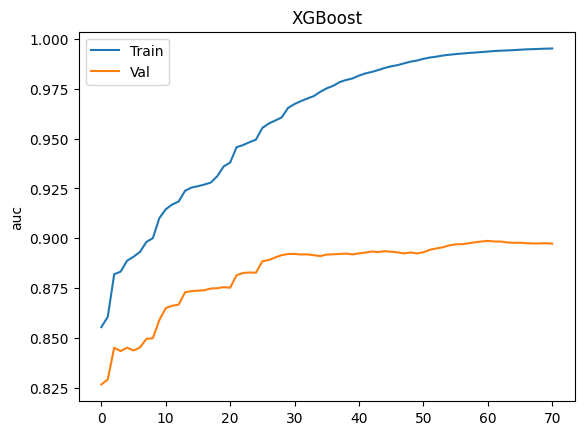

In [ ]:
# Option 2: Use XGBoost Library to fit it
# It allows you to use an `early_stopping` criteria with a Train/Val slit
X_train_preproc = preproc.fit_transform(X_train, y_train)
X_test_preproc = preproc.transform(X_test)

model_xgb.fit(X_train_preproc, y_train,
        verbose=False,
        eval_set=[(X_train_preproc, y_train), (X_test_preproc, y_test)],
        eval_metric=["auc"],
        early_stopping_rounds=10)

# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']["auc"])
x_axis = range(0, epochs)

# plot rmsle loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Val')
ax.legend(); plt.ylabel('auc'); plt.title('XGBoost')

print("Best Validation Score", min(results['validation_1']['auc']))

In [ ]:
# It would have been good to check the results of the XGBoost fined tuned

In [ ]:
# see where is written the code where I create the enviroment for this project 

In [ ]:
# models I'm not using 
# Ridge, Lasso
# Ensemble: VotingClassifier, reading the doc I believe it makes more sense to use StackingClassifier

In [ ]:
# # Clear the cache directory at the end
# rmtree(cachedir)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

2023-05-06 00:25:47.626783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.10.0
